In [1]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt 
import numpy as np
import scipy.io
from process_data_rnn_ssm import min_max_scaler,sliding_window
from sklearn import preprocessing
plt.rcParams.update({'font.size': 22})
import os, os.path
import pandas as pd
plt.rcParams["figure.figsize"] = (20,10)
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import StandardScaler, MinMaxScaler
plt.rcParams.update({'font.size': 22})
from scipy import signal
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (20,10)
import mne
from train_VRNN import decode_z
from eeg_config import Config
import pickle

In [39]:
mat = scipy.io.loadmat('iravani_neuro_data/SL07_02/eeg_data_session_01.mat')
trials = mat['data_eeg'][0][0][4][1][0][0]
ch_names = []
for arr in mat['data_eeg'][0][0][4]:
    ch_names.append(arr[0][0])
#print(ch_names[0])

n_channels = 64
sampling_freq = 256  # in Hertz
info = mne.create_info(n_channels, sfreq=sampling_freq)
#print(info)

#ch_names = [f'MEG{n:03}' for n in range(1, 10)] + ['EOG001']
ch_names = ch_names[0:64]
ch_types = ['eeg'] * 64
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
#print(info)
info.set_montage('biosemi64')

def scale_back(data,scalers):
    unscaled_data = np.zeros(data.shape)
    for i,row in enumerate(data):
        #print(i)
        row = row.reshape((1,int(row.shape[0]*row.shape[1])))
        unscaled_row = scalers[i].inverse_transform(row)
        unscaled_row = unscaled_row.reshape((768,64))
        unscaled_data[i] = unscaled_row
    return unscaled_data

def get_trial_per_participant(data,trials_per_participant):
    mean_per_p = np.zeros((19,768,4))
    for i, n in enumerate(trials_per_participant):
        prev = int(np.sum(trials_per_participant[0:i]))
        if n != 0:
            for j in range(int(n)):
                mean_per_p[i] +=data[j+prev]
            mean_per_p[i]/n
    return mean_per_p


# Load and check z

In [48]:
z_ple = np.load("z_ple_4_100.npy")
z_dis = np.load("z_dis_4_100.npy")
trials_per_participant_ple = np.load("trials_per_participant_ple.npy")
trials_per_participant_dis = np.load("trials_per_participant_dis.npy")

(70, 768, 64)
(70, 768, 64)


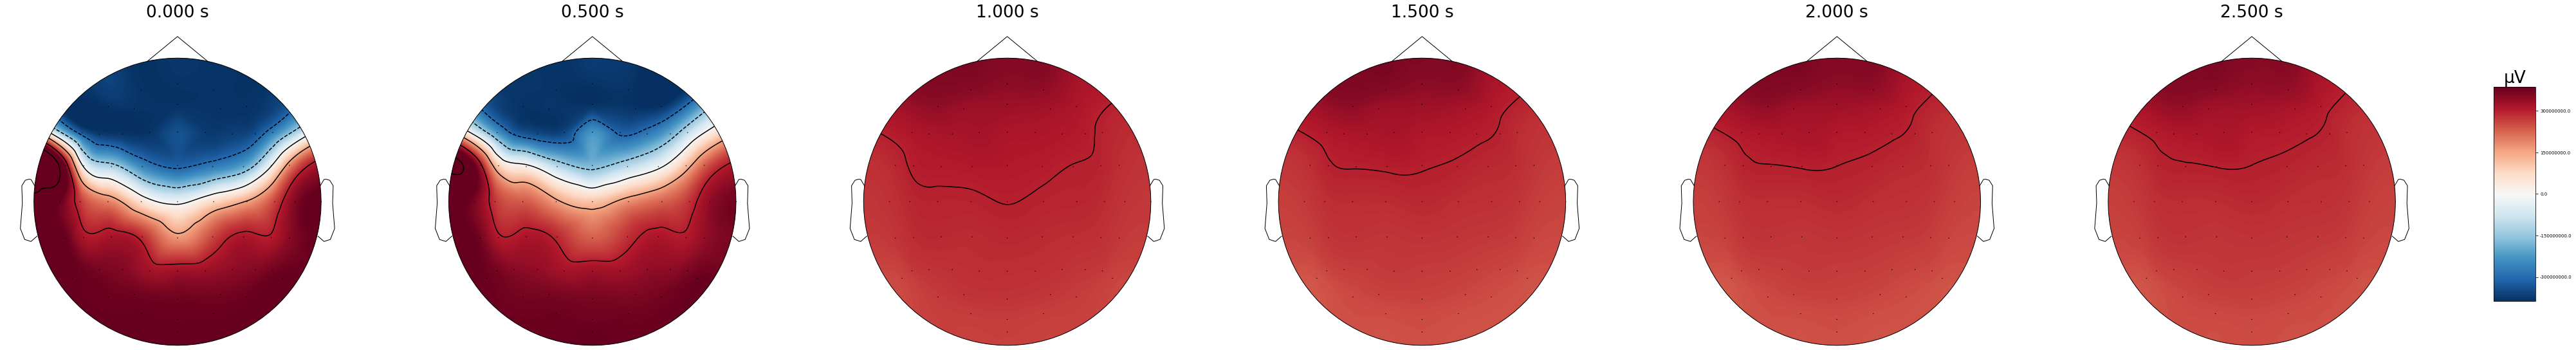

In [4]:


conf = Config()
#for i in range(len(x_arr)):
x = decode_z(conf,z_dis,0,0,True)
#plt.plot(x[:,0])
print(x.shape)
with open('dis_test_scaler.pickle','rb') as f:
    scalers = pickle.load(f)

#print(x.shape)
all_x = np.zeros((z_ple.shape[0],768,64))
for i in range(len(x)):
    
    x_s = scalers[i].inverse_transform(x[i].reshape(1,int(x.shape[1]*x.shape[2]))).reshape(x.shape[1],x.shape[2])
    all_x[i] = x_s
    
#plt.plot(x_s[:,1])
print(x.shape)

mean_dis = get_trial_per_participant(all_x,trials_per_participant_dis)
total_mean_dis = np.mean(mean_dis,axis=0)

times = np.arange(0, 2.99, 0.5)
evoked_array = mne.EvokedArray(total_mean_dis.T, info, tmin=0,
                           nave=x_s.shape[0], comment='simulated')
fig = evoked_array.plot_topomap(times, ch_type='eeg', time_unit='s',colorbar=True,
                size=6, res=128,show=False)

(70, 768, 64)
(70, 768, 64)


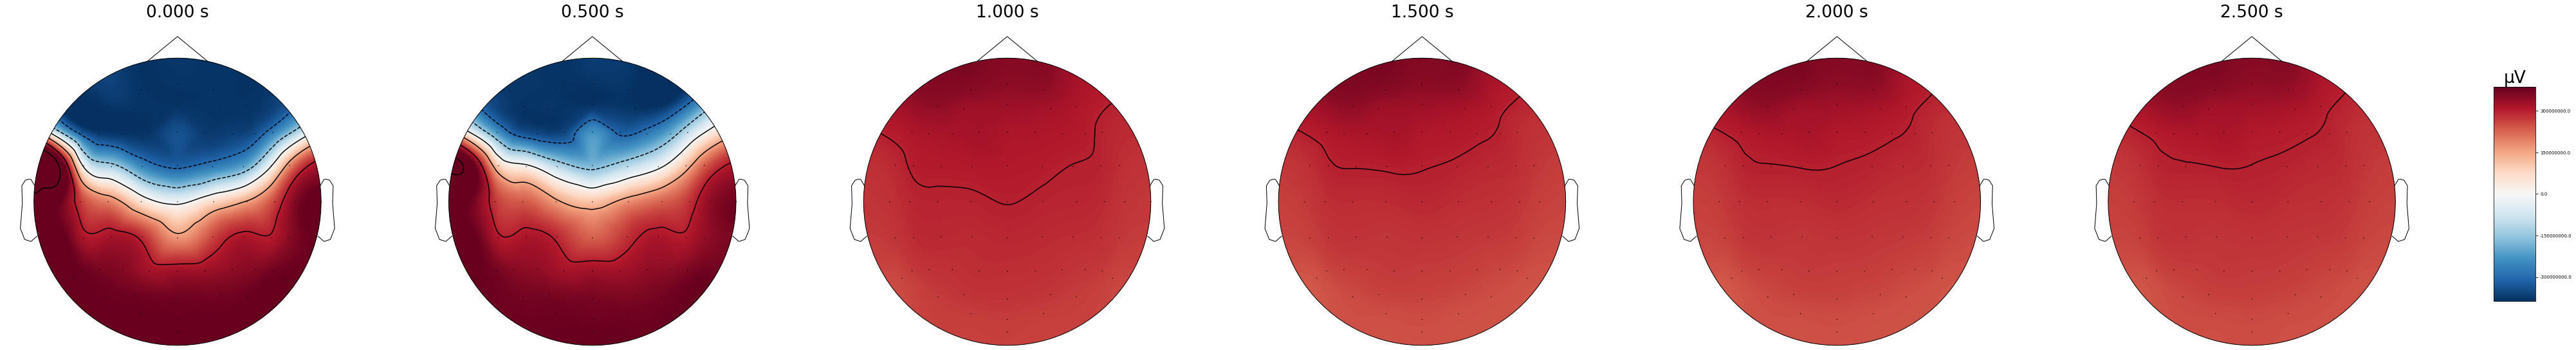

In [4]:
conf = Config()
#for i in range(len(x_arr)):
x = decode_z(conf,z_dis,0,0,False)
#plt.plot(x[:,0])
print(x.shape)
with open('dis_test_scaler.pickle','rb') as f:
    scalers = pickle.load(f)

#print(x.shape)
all_x = np.zeros((z_ple.shape[0],768,64))
for i in range(len(x)):
    
    x_s = scalers[i].inverse_transform(x[i].reshape(1,int(x.shape[1]*x.shape[2]))).reshape(x.shape[1],x.shape[2])
    all_x[i] = x_s
    
#plt.plot(x_s[:,1])
print(x.shape)

mean_dis = get_trial_per_participant(all_x,trials_per_participant_dis)
total_mean_dis = np.mean(mean_dis,axis=0)

times = np.arange(0, 2.99, 0.5)
evoked_array = mne.EvokedArray(total_mean_dis.T, info, tmin=0,
                           nave=x_s.shape[0], comment='simulated')
fig = evoked_array.plot_topomap(times, ch_type='eeg', time_unit='s',colorbar=True,
                size=6, res=128,show=False)

Scipy computed Pearson r: -0.02267369936590051 and p-value: 0.6574037451650661 for z 0 and 1
Scipy computed Pearson r: 0.04626932106684646 and p-value: 0.36525214652841503 for z 0 and 2
Scipy computed Pearson r: 0.0543935498154294 and p-value: 0.28705859454294624 for z 0 and 3
Scipy computed Pearson r: 0.006427395890811845 and p-value: 0.8999647816449888 for z 1 and 2
Scipy computed Pearson r: 0.03318764485825408 and p-value: 0.5161767526752203 for z 1 and 3
Scipy computed Pearson r: -0.05958428388372775 and p-value: 0.24346769167168972 for z 2 and 3


'\nfor i in range(total_mean_dis_z.shape[1]):\n    #plt.figure(i)\n    #plt.plot(total_mean_ple_z[:,i])\n    #plt.plot(total_mean_dis_z[:,i])\n    plt.figure(10+i)\n    r, p = stats.pearsonr(total_mean_ple_z[:,i], total_mean_dis_z[:,i])\n    print(f"Scipy computed Pearson r: {r} and p-value: {p} for graph {i}")\n    \n    f_s = 256  # Sampling rate, or number of measurements per second\n    f, Pxx_1 = signal.periodogram(total_mean_ple_z[:,0], f_s)\n    plt.semilogy(f[1:-1], Pxx_1[1:-1])\n    plt.ylabel("PSD [V**2]")\n    plt.xlabel("Frequency [Hz]")\n    f, Pxx_2 = signal.periodogram(total_mean_dis_z[:,0], f_s)\n    plt.semilogy(f[1:-1], Pxx_2[1:-1])\n    plt.ylabel("PSD [V**2]")\n    plt.xlabel("Frequency [Hz]")\n    r, p = stats.pearsonr(Pxx_1, Pxx_2)\n    print(f"Scipy computed Pearson r: {r} and p-value: {p} for fourier spectra {i}" )\n    plt.savefig("z_fourier_4_b1_1000")\n'

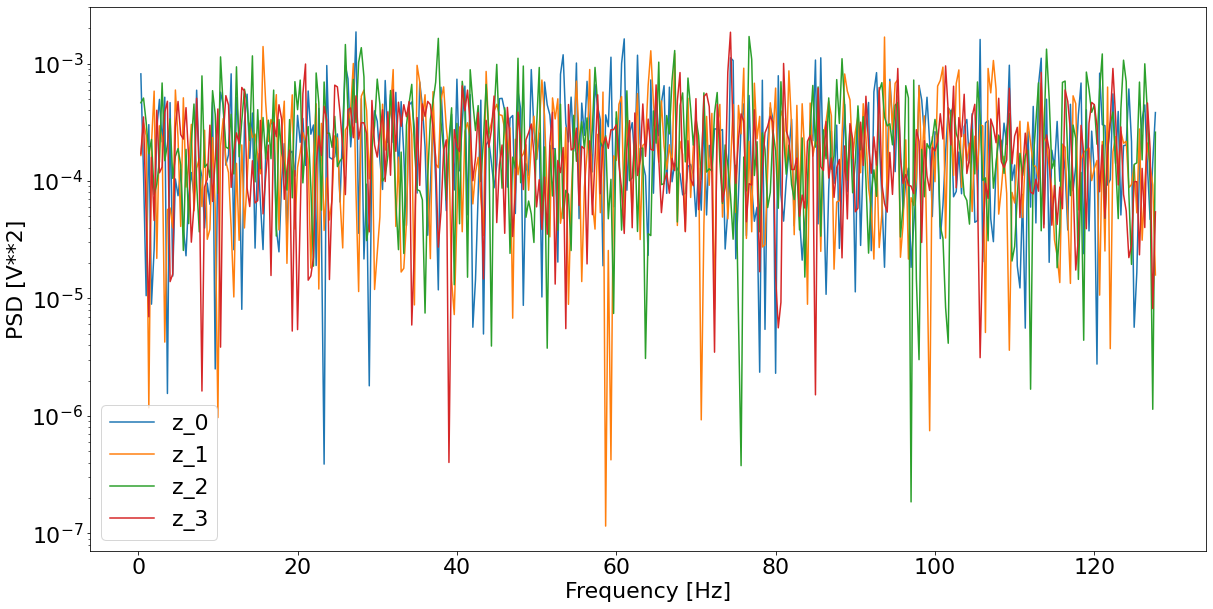

In [49]:
mean_ple_z = get_trial_per_participant(z_ple,trials_per_participant_ple)
total_mean_ple_z = np.mean(mean_ple_z,axis=0)
mean_dis_z = get_trial_per_participant(z_dis,trials_per_participant_dis)
total_mean_dis_z = np.mean(mean_dis_z,axis=0)
pxx_s = []
for i in range(total_mean_dis_z.shape[1]):
    f, Pxx_2 = signal.periodogram(total_mean_dis_z[:,i], f_s)
    plt.semilogy(f[1:-1], Pxx_2[1:-1])
    plt.ylabel("PSD [V**2]")
    plt.xlabel("Frequency [Hz]")
    plt.legend(["z_0","z_1","z_2","z_3"])
    pxx_s.append(Pxx_2)

#plt.savefig("z_fourier_b1000")
r, p = stats.pearsonr(pxx_s[0], pxx_s[1]) 
print(f"Scipy computed Pearson r: {r} and p-value: {p} for z 0 and 1")   
r, p = stats.pearsonr(pxx_s[0], pxx_s[2]) 
print(f"Scipy computed Pearson r: {r} and p-value: {p} for z 0 and 2")    
r, p = stats.pearsonr(pxx_s[0], pxx_s[3]) 
print(f"Scipy computed Pearson r: {r} and p-value: {p} for z 0 and 3")
r, p = stats.pearsonr(pxx_s[1], pxx_s[2]) 
print(f"Scipy computed Pearson r: {r} and p-value: {p} for z 1 and 2")
r, p = stats.pearsonr(pxx_s[1], pxx_s[3]) 
print(f"Scipy computed Pearson r: {r} and p-value: {p} for z 1 and 3")
r, p = stats.pearsonr(pxx_s[2], pxx_s[3]) 
print(f"Scipy computed Pearson r: {r} and p-value: {p} for z 2 and 3")    

"""
for i in range(total_mean_dis_z.shape[1]):
    #plt.figure(i)
    #plt.plot(total_mean_ple_z[:,i])
    #plt.plot(total_mean_dis_z[:,i])
    plt.figure(10+i)
    r, p = stats.pearsonr(total_mean_ple_z[:,i], total_mean_dis_z[:,i])
    print(f"Scipy computed Pearson r: {r} and p-value: {p} for graph {i}")
    
    f_s = 256  # Sampling rate, or number of measurements per second
    f, Pxx_1 = signal.periodogram(total_mean_ple_z[:,0], f_s)
    plt.semilogy(f[1:-1], Pxx_1[1:-1])
    plt.ylabel("PSD [V**2]")
    plt.xlabel("Frequency [Hz]")
    f, Pxx_2 = signal.periodogram(total_mean_dis_z[:,0], f_s)
    plt.semilogy(f[1:-1], Pxx_2[1:-1])
    plt.ylabel("PSD [V**2]")
    plt.xlabel("Frequency [Hz]")
    r, p = stats.pearsonr(Pxx_1, Pxx_2)
    print(f"Scipy computed Pearson r: {r} and p-value: {p} for fourier spectra {i}" )
    plt.savefig("z_fourier_4_b1_1000")
"""

In [8]:

x_arr_mean = np.mean(all_x,axis=0)

(292, 768, 64)
0.9998841217217105
heh


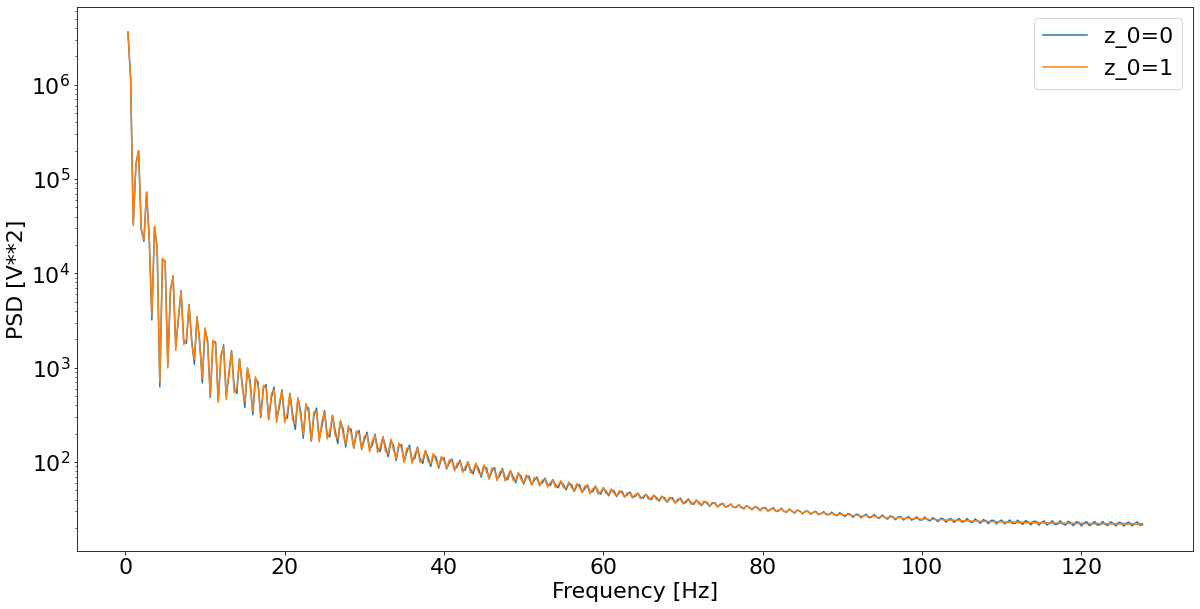

In [37]:
for i in range(1):

    conf = Config()
    x = decode_z(conf,z_dis,i,0,True)
    #plt.plot(x[:,0])
    print(x.shape)
    with open('scalers_train.pickle','rb') as f:
        scalers = pickle.load(f)

    #print(x.shape)
    all_x = np.zeros((len(x),768,64))
    for j in range(len(x)):

        x_s = scalers[j].inverse_transform(x[j].reshape(1,int(x.shape[1]*x.shape[2]))).reshape(x.shape[1],x.shape[2])
        all_x[j] = x_s
    
    mean_ple = get_trial_per_participant(all_x,trials_per_participant_dis)
    total_mean_ple = np.mean(mean_ple,axis=0)
    
    
    x = decode_z(conf,z_dis,i,1,True)
    with open('scalers_train.pickle','rb') as f:
        scalers = pickle.load(f)

    all_x_2 = np.zeros((len(x),768,64))
    for j in range(len(x)):

        x_s = scalers[j].inverse_transform(x[j].reshape(1,int(x.shape[1]*x.shape[2]))).reshape(x.shape[1],x.shape[2])
        all_x_2[j] = x_s
    #print(x.shape)
    
    mean_ple = get_trial_per_participant(all_x_2,trials_per_participant_dis)
    total_mean_ple_2 = np.mean(mean_ple,axis=0)

    #plt.plot(x_arr_mean_2[:,0])
    corr_arr = np.zeros(total_mean_ple.shape[1])
    for j in range(total_mean_ple.shape[1]):
        r, p = stats.pearsonr(total_mean_ple[:,j], total_mean_ple_2[:,j])
        corr_arr[j] = r
    print(np.mean(corr_arr))
    times = np.arange(-0.5, 2.49, 0.5)
    #evoked_array = mne.EvokedArray(abs(total_mean_ple.T) -abs(total_mean_ple_2.T), info, tmin=-0.5,
    #                           nave=x_s.shape[0], comment='simulated')
    #fig = evoked_array.plot_topomap(times, ch_type='eeg', time_unit='s',colorbar=True,
    #                size=6, res=128,show=False)
    f_s = 256  # Sampling rate, or number of measurements per second
    #print(total_mean_ple.shape)
    #plt.savefig("z_dis_"+str(i))
    #f, Pxx_1 = signal.periodogram(total_mean_ple[:,0], f_s)
    #plt.semilogy(f[1:-1], Pxx_1[1:-1])
    #f, Pxx_2 = signal.periodogram(total_mean_ple_2[:,0], f_s)
    #plt.semilogy(f[1:-1], Pxx_2[1:-1])
    
    f_s = 256  # Sampling rate, or number of measurements per second
    corr_arr_f = []
    
    f, Pxx_1 = signal.periodogram(total_mean_ple[:,0], f_s)
    plt.semilogy(f[1:-1], Pxx_1[1:-1])
    plt.ylabel("PSD [V**2]")
    plt.xlabel("Frequency [Hz]")
    f, Pxx_2 = signal.periodogram(total_mean_ple_2[:,0], f_s)
    plt.semilogy(f[1:-1], Pxx_2[1:-1])
    plt.ylabel("PSD [V**2]")
    plt.xlabel("Frequency [Hz]")
    plt.legend(["z_0=0","z_0=1"])
    plt.savefig("z0_change_psd_1000")
    """
    for i in range(64):
        f, Pxx_1 = signal.periodogram(total_mean_ple[:,0], f_s)
        #plt.semilogy(f[1:-1], Pxx_1[1:-1])
        #plt.ylabel("PSD [V**2]")
        #plt.xlabel("Frequency [Hz]")
        f, Pxx_2 = signal.periodogram(total_mean_ple_2[:,0], f_s)
        #plt.semilogy(f[1:-1], Pxx_2[1:-1])
        #plt.ylabel("PSD [V**2]")
        #plt.xlabel("Frequency [Hz]")
        r, p = stats.pearsonr(Pxx_1, Pxx_2)
        #print(f"Scipy computed Pearson r: {r} and p-value: {p} for fourier spectra {i}" )
        #plt.savefig("z_fourier_4_b1_1000")
        corr_arr_f.append(r)
    print(np.mean(corr_arr))
    """
print("heh")

(111, 768, 64)
0.9995408637679202


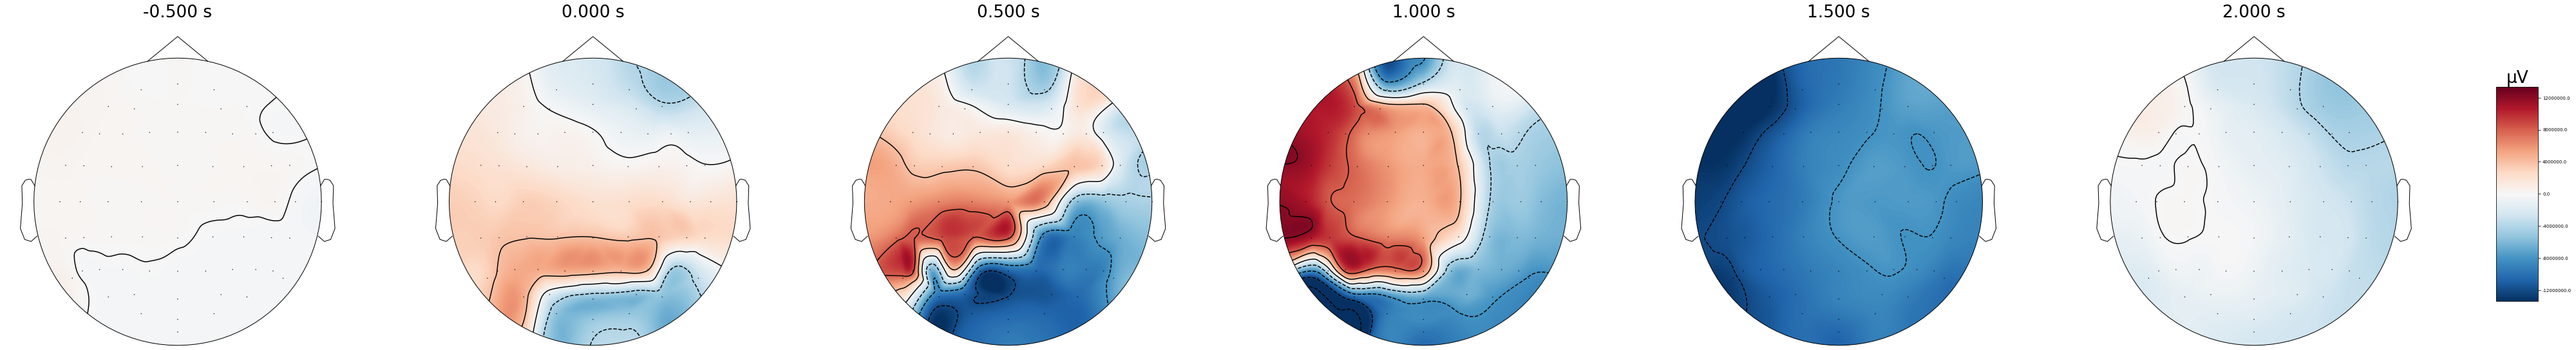

(768, 64)
(111, 768, 64)
0.9989303293433464


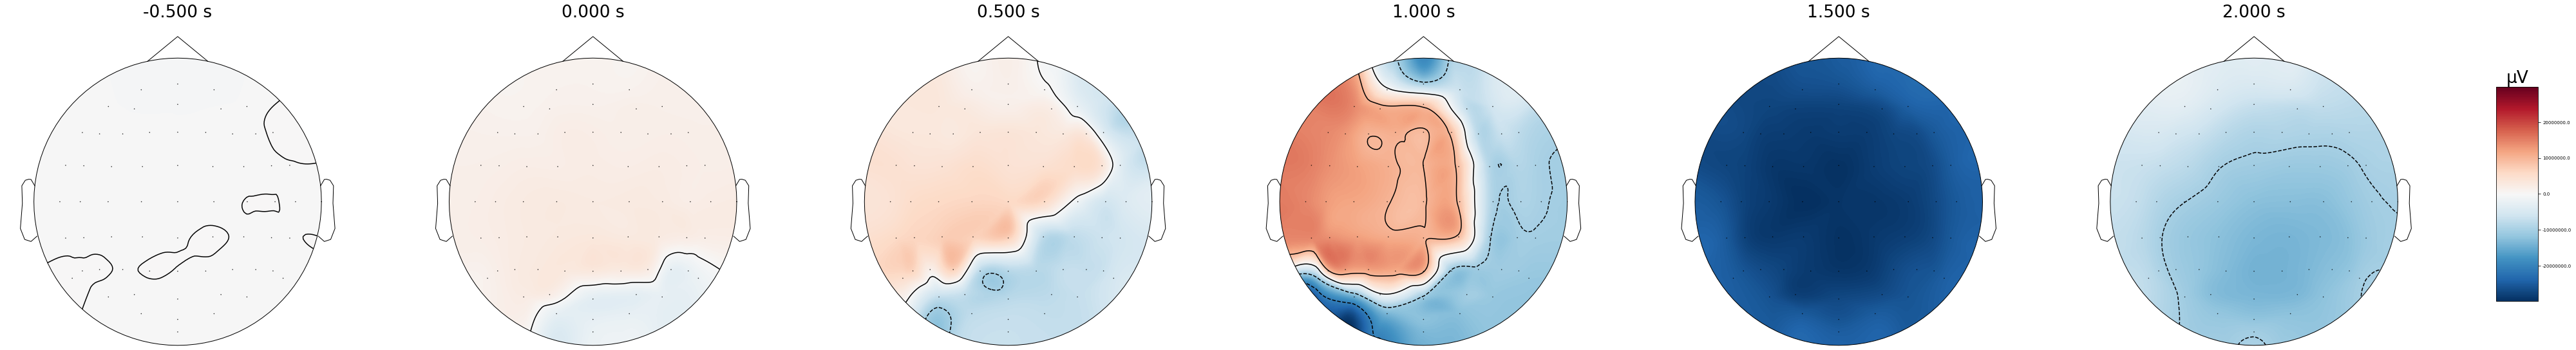

(768, 64)
(111, 768, 64)
0.9989141813715292


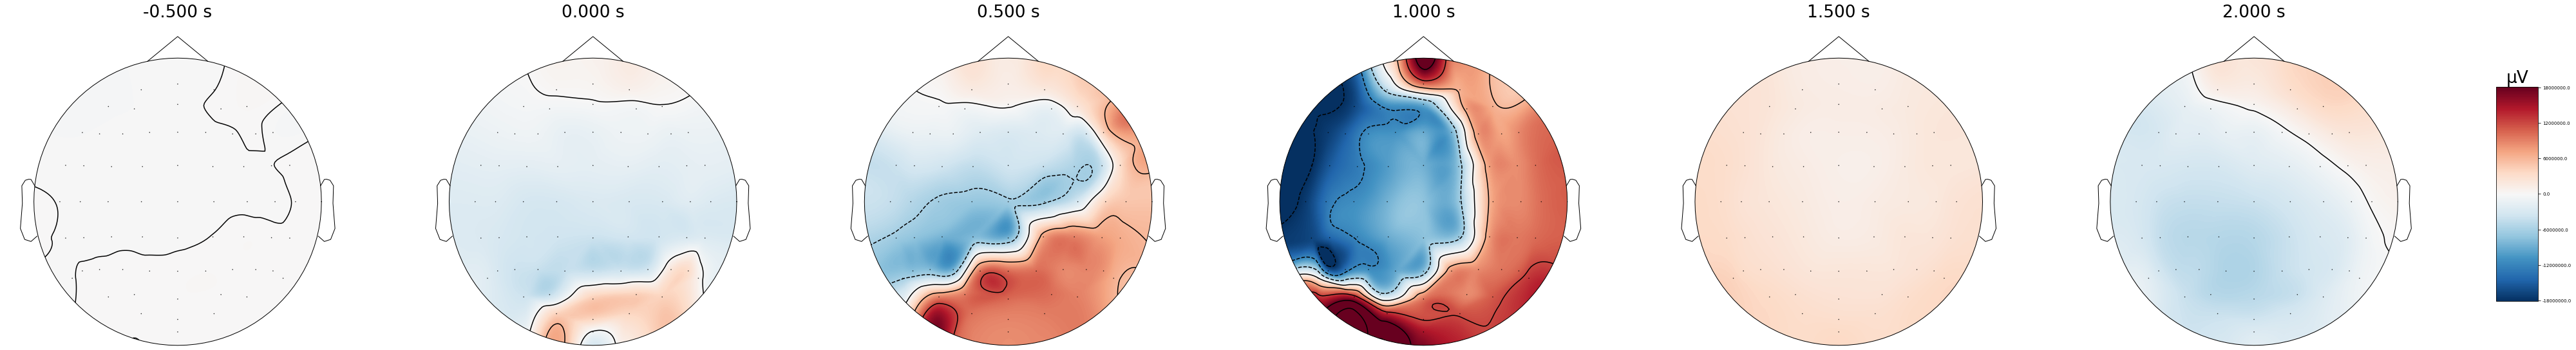

(768, 64)
(111, 768, 64)
0.9993311632769999


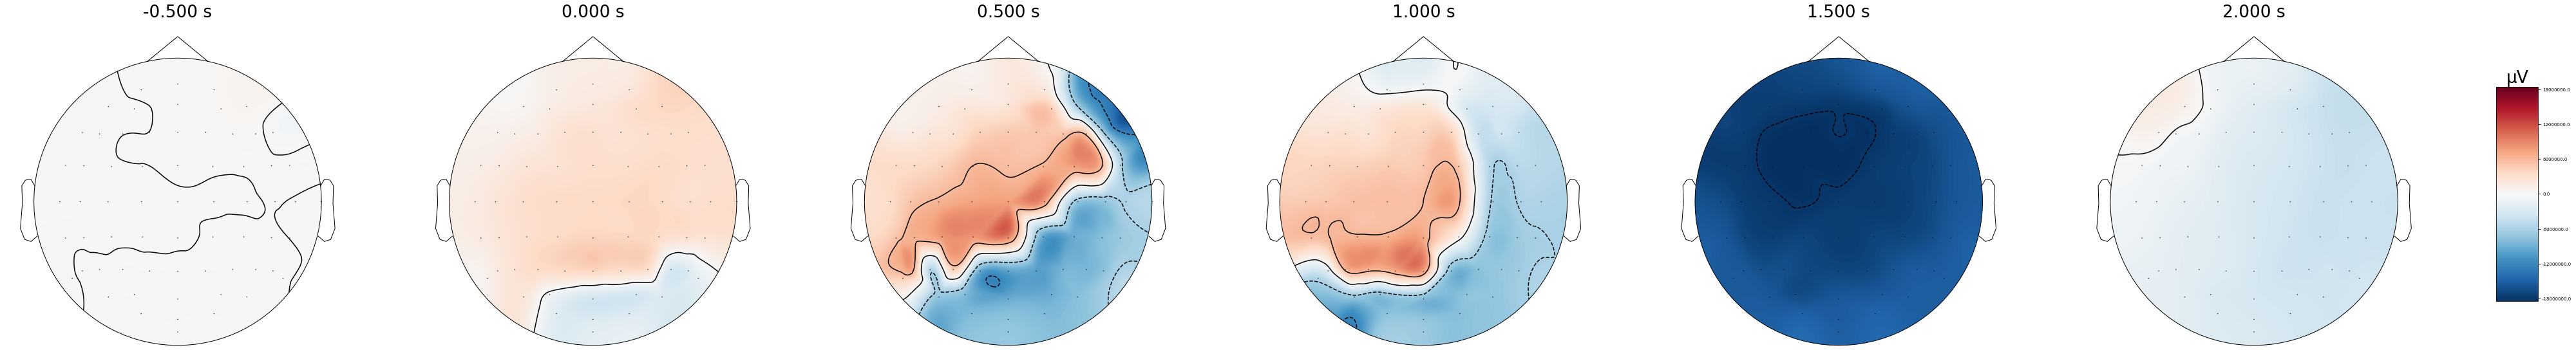

(768, 64)
heh


In [7]:
for i in range(4):

    conf = Config()
    x = decode_z(conf,z_ple,i,0,True)
    #plt.plot(x[:,0])
    print(x.shape)
    with open('scalers_train.pickle','rb') as f:
        scalers = pickle.load(f)

    #print(x.shape)
    all_x = np.zeros((len(x),768,64))
    for j in range(len(x)):

        x_s = scalers[j].inverse_transform(x[j].reshape(1,int(x.shape[1]*x.shape[2]))).reshape(x.shape[1],x.shape[2])
        all_x[j] = x_s
    
    mean_ple = get_trial_per_participant(all_x,trials_per_participant_ple)
    total_mean_ple = np.mean(mean_ple,axis=0)
    
    
    x = decode_z(conf,z_ple,i,1,True)
    with open('scalers_train.pickle','rb') as f:
        scalers = pickle.load(f)

    all_x_2 = np.zeros((len(x),768,64))
    for j in range(len(x)):

        x_s = scalers[j].inverse_transform(x[j].reshape(1,int(x.shape[1]*x.shape[2]))).reshape(x.shape[1],x.shape[2])
        all_x_2[j] = x_s
    #print(x.shape)
    
    mean_ple = get_trial_per_participant(all_x_2,trials_per_participant_ple)
    total_mean_ple_2 = np.mean(mean_ple,axis=0)

    #plt.plot(x_arr_mean_2[:,0])
    corr_arr = np.zeros(total_mean_ple.shape[1])
    for j in range(total_mean_ple.shape[1]):
        r, p = stats.pearsonr(total_mean_ple[:,j], total_mean_ple_2[:,j])
        corr_arr[j] = r
    print(np.mean(corr_arr))
    times = np.arange(-0.5, 2.49, 0.5)
    evoked_array = mne.EvokedArray(abs(total_mean_ple.T) -abs(total_mean_ple_2.T), info, tmin=-0.5,
                               nave=x_s.shape[0], comment='simulated')
    evoked_array.plot_topomap(times, ch_type='eeg', time_unit='s',colorbar=True,
                    size=6, res=128)
    f_s = 256  # Sampling rate, or number of measurements per second
    print(total_mean_ple.shape)
    #f, Pxx_1 = signal.periodogram(total_mean_ple[:,0], f_s)
    #plt.semilogy(f[1:-1], Pxx_1[1:-1])
    #f, Pxx_2 = signal.periodogram(total_mean_ple_2[:,0], f_s)
    #plt.semilogy(f[1:-1], Pxx_2[1:-1])

print("heh")

0.9974832317360846


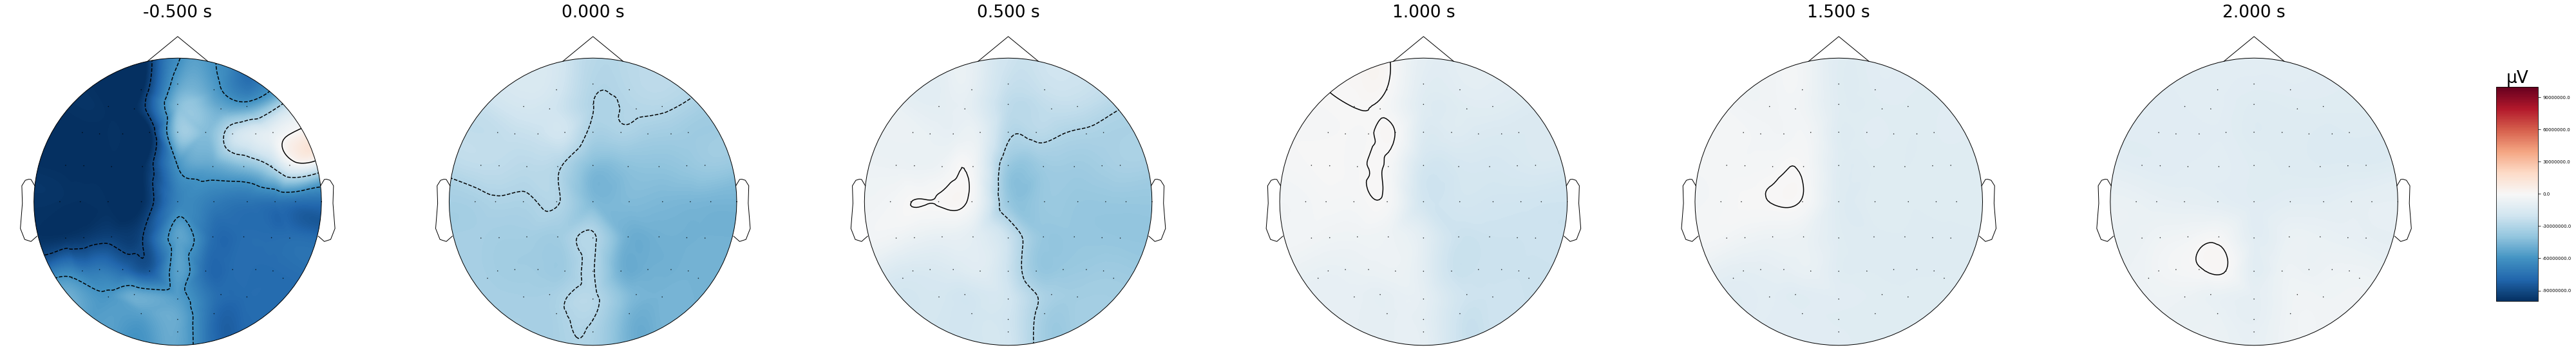

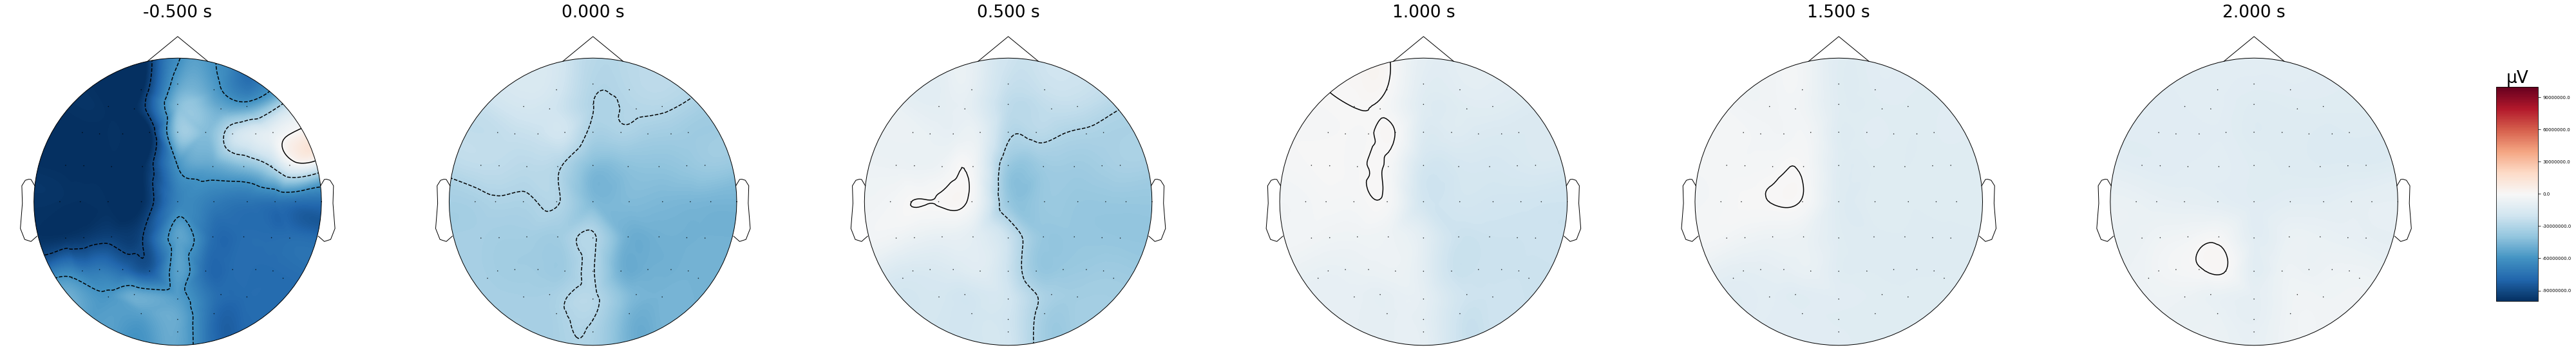

In [16]:


conf = Config()

x = decode_z(conf,z_train,0,0,False)
with open('scalers_train.pickle','rb') as f:
    scalers = pickle.load(f)

all_x_2 = np.zeros((100,384,64))
for i in range(len(x)):
    
    x_s = scalers[i].inverse_transform(x[i].reshape(1,int(x.shape[1]*x.shape[2]))).reshape(x.shape[1],x.shape[2])
    all_x_2[i] = x_s
#print(x.shape)


x_arr_mean_2 = np.mean(all_x_2,axis=0)
#plt.plot(x_arr_mean_2[:,0])
corr_arr = np.zeros(x_arr_mean.shape[1])
for i in range(x_arr_mean.shape[1]):
    r, p = stats.pearsonr(x_arr_mean[:,i], x_arr_mean_2[:,i])
    corr_arr[i] = r
print(np.mean(corr_arr))
times = np.arange(-0.5, 2.49, 0.5)
evoked_array = mne.EvokedArray(abs(x_arr_mean.T) -abs(x_arr_mean_2.T), info, tmin=-0.5,
                           nave=x_s.shape[0], comment='simulated')
evoked_array.plot_topomap(times, ch_type='eeg', time_unit='s',colorbar=True,
                size=6, res=128)

Restore model
(384, 64)
0.9229538199192407


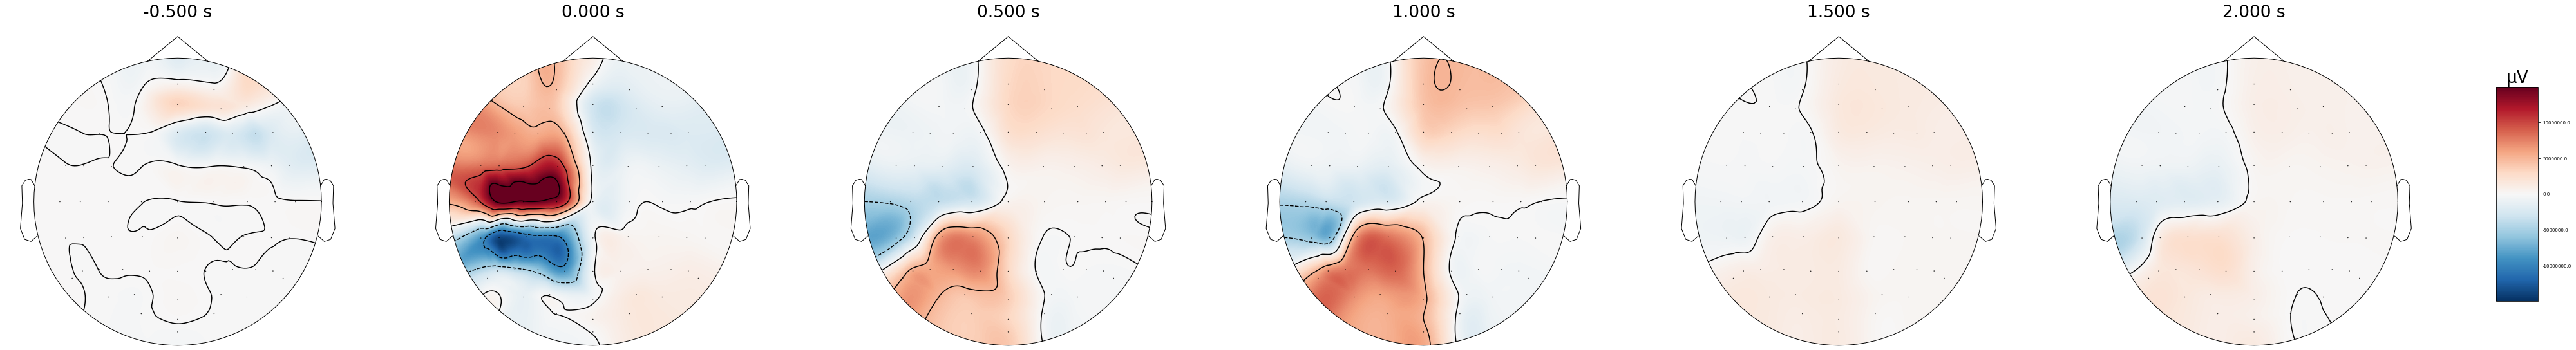

Restore model
(384, 64)
0.9486782139532768


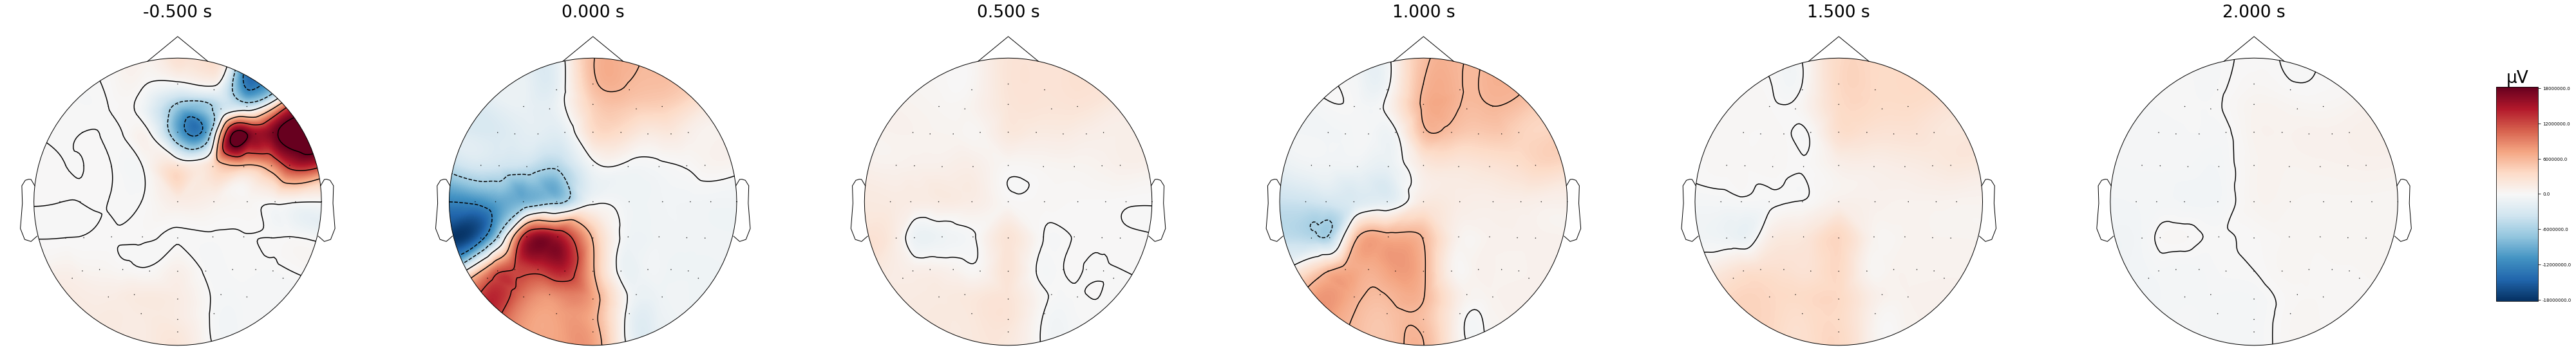

Restore model
(384, 64)
0.021015885263493968


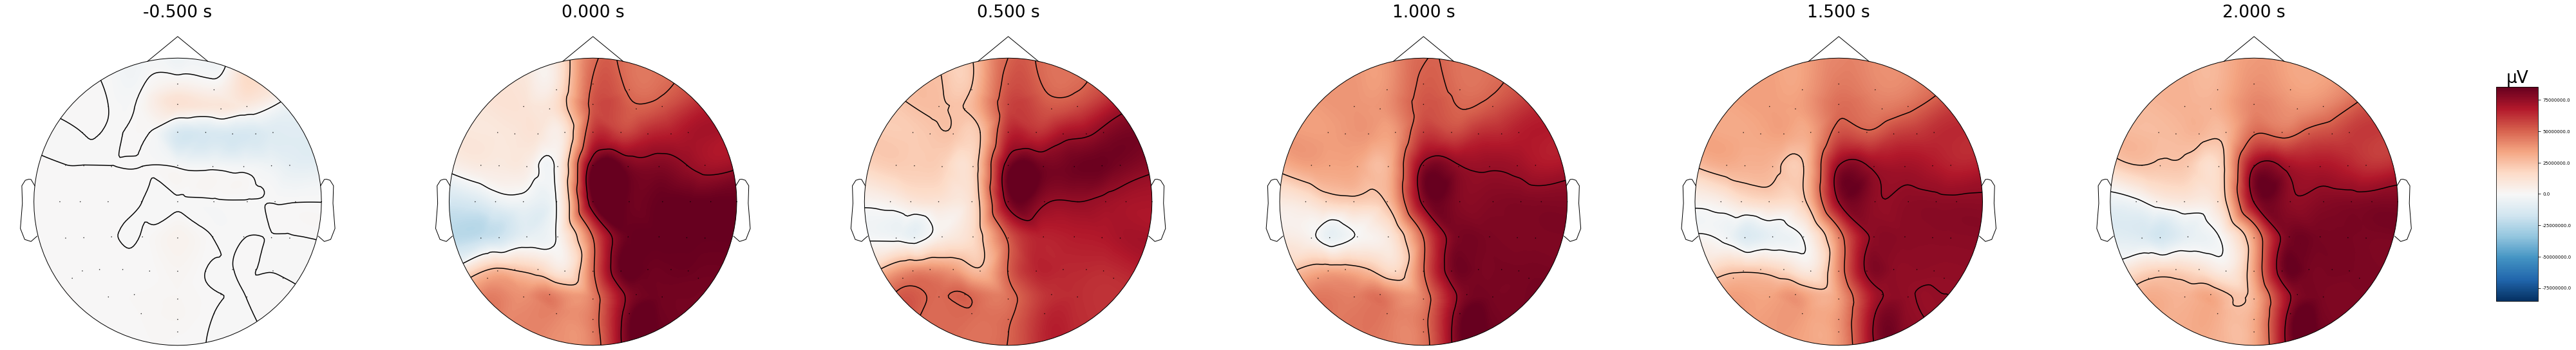

In [28]:

for i in range(100):
    conf = Config()
    x = generating(conf,i,0,True)
    with open('scalers_train.pickle','rb') as f:
        scalers = pickle.load(f)

    #print(x.shape)
    x_s_2 = scalers[0].inverse_transform(x.reshape(1,int(x.shape[0]*x.shape[1]))).reshape(x.shape[0],x.shape[1])

    #plt.plot(x_s_2[:,1])
    print(x.shape)
    corr_arr = np.zeros(x_s.shape[1])

    for i in range(x_s.shape[1]):
        r, p = stats.pearsonr(x_s[:,i], x_s_2[:,i])
        corr_arr[i] = r
    print(np.mean(corr_arr))
    times = np.arange(-0.5, 2.49, 0.5)
    evoked_array = mne.EvokedArray(abs(x_s.T) -abs(x_s_2.T), info, tmin=-0.5,
                                   nave=x_s.shape[0], comment='simulated')
    evoked_array.plot_topomap(times, ch_type='eeg', time_unit='s',colorbar=True,
                        size=6, res=128)

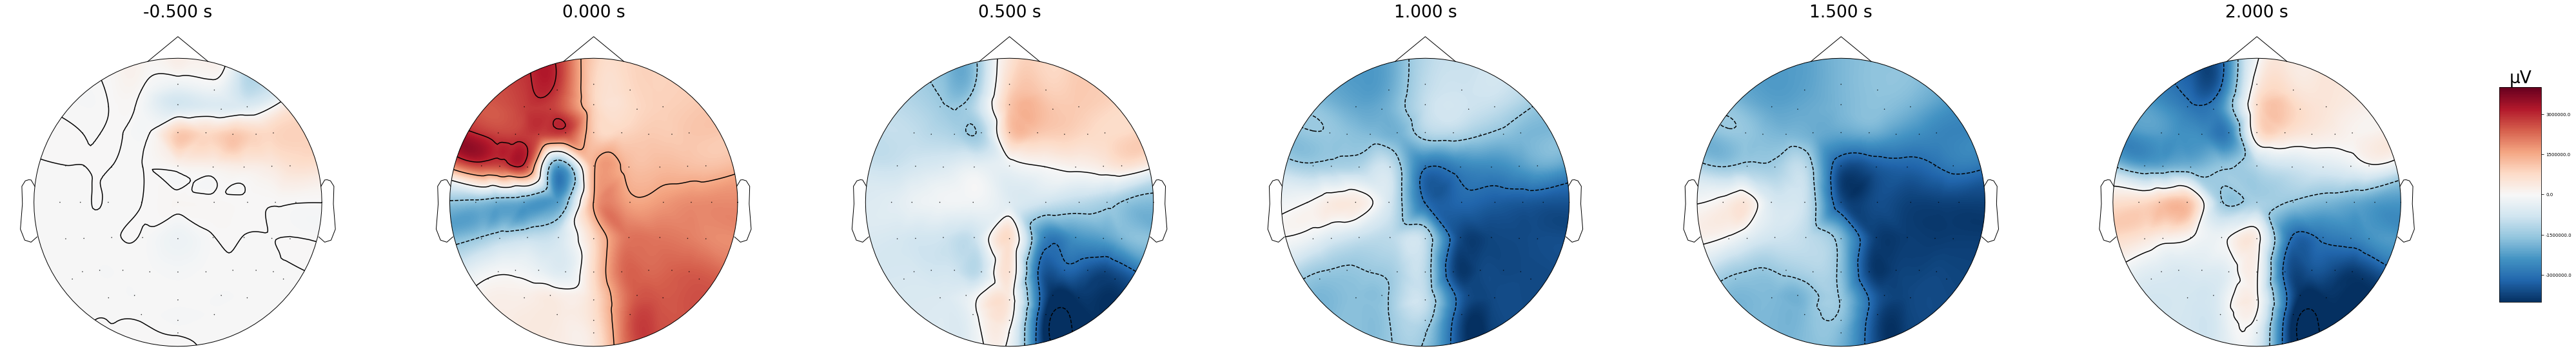

he


In [44]:
times = np.arange(-0.5, 2.49, 0.5)
evoked_array = mne.EvokedArray(abs(x_arr_mean.T) -abs(x_arr_mean_2.T), info, tmin=-0.5,
                               nave=x_s.shape[0], comment='simulated')
evoked_array.plot_topomap(times, ch_type='eeg', time_unit='s',colorbar=True,
                    size=6, res=128)
print("he")

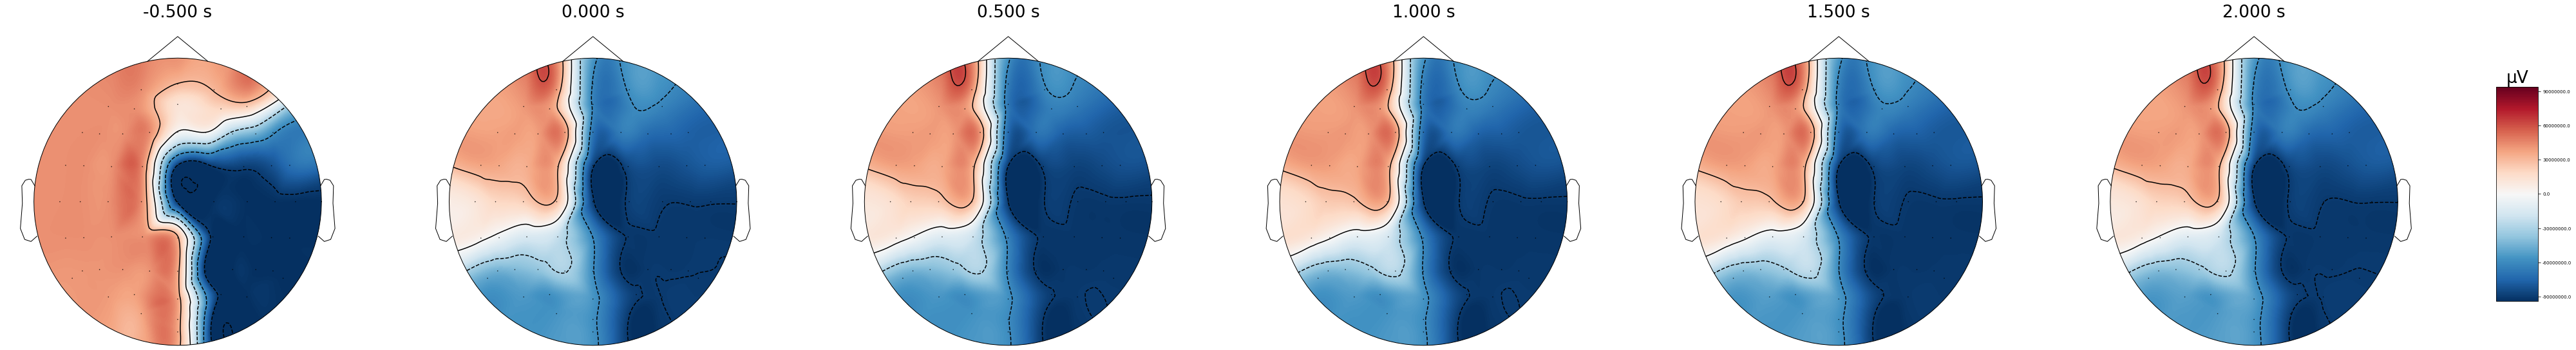

he


In [11]:
times = np.arange(-0.5, 2.49, 0.5)
evoked_array = mne.EvokedArray(x_s.T, info, tmin=-0.5,
                               nave=x_s.shape[0], comment='simulated')
evoked_array.plot_topomap(times, ch_type='eeg', time_unit='s',colorbar=True,
                    size=6, res=128)

print("he")

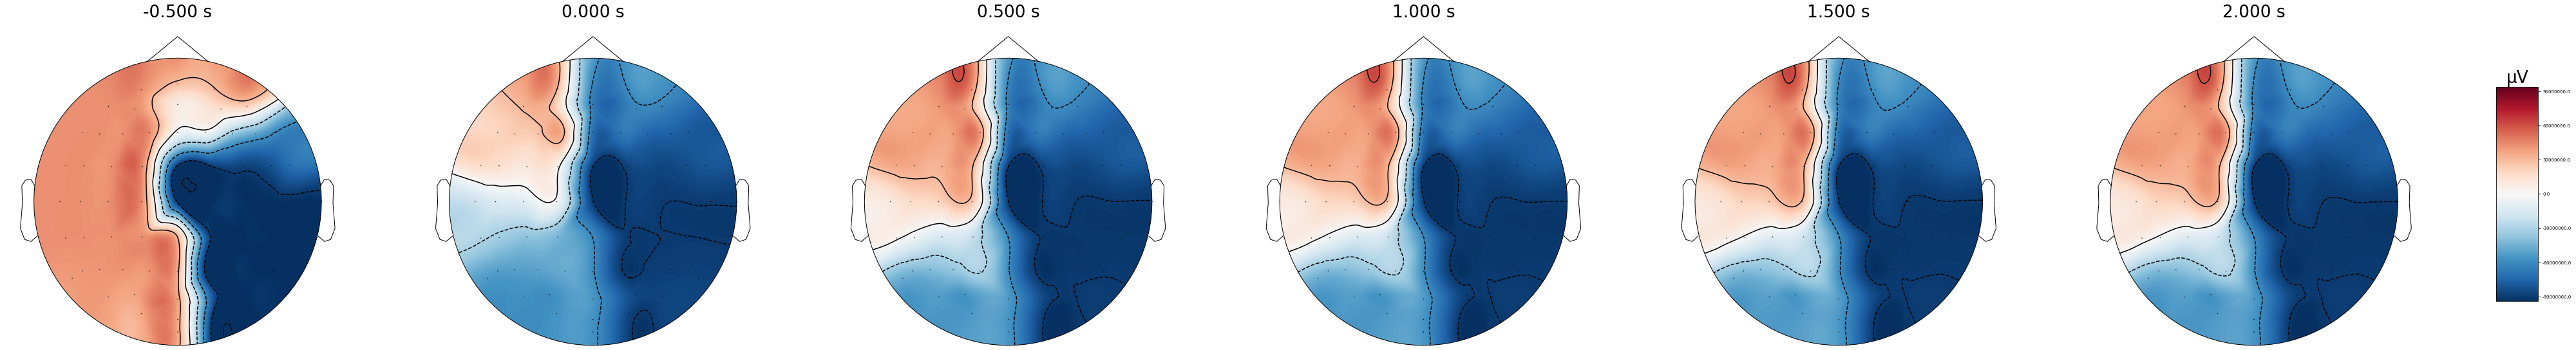

he


In [14]:
times = np.arange(-0.5, 2.49, 0.5)
evoked_array = mne.EvokedArray(x_s_2.T, info, tmin=-0.5,
                               nave=x_s.shape[0], comment='simulated')
evoked_array.plot_topomap(times, ch_type='eeg', time_unit='s',colorbar=True,
                    size=6, res=128)
print("he")

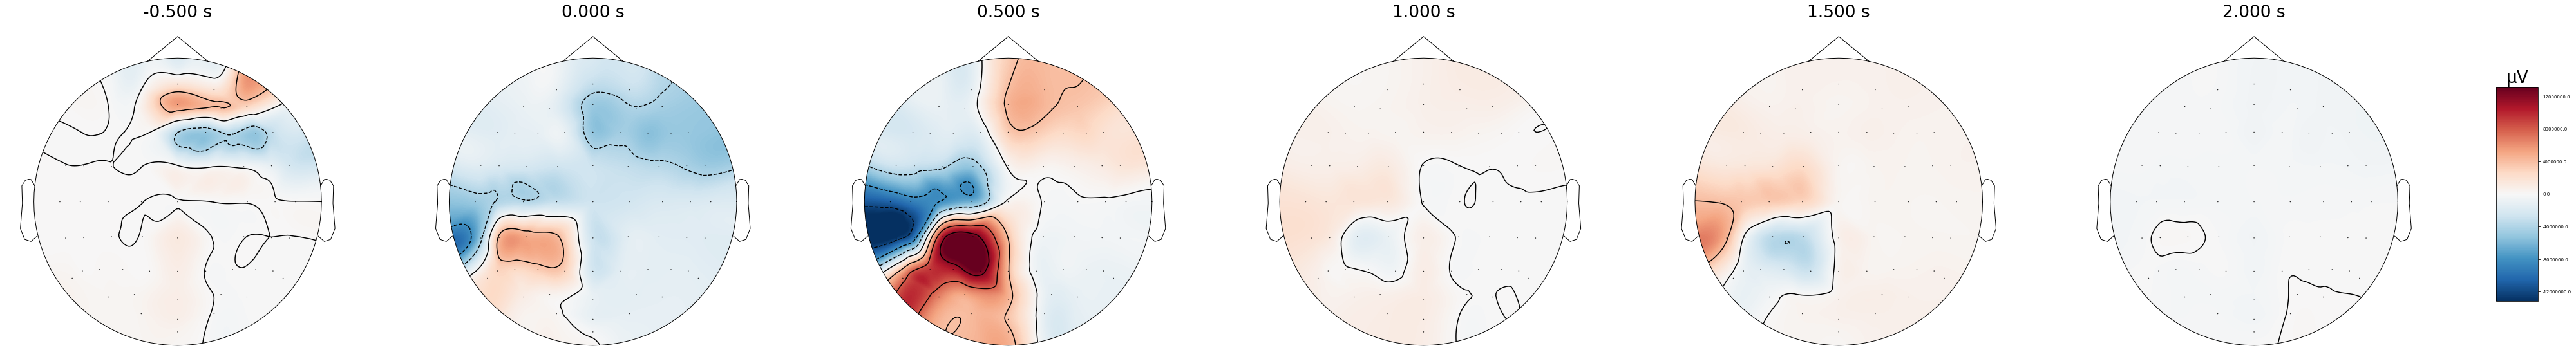

he


In [1]:
from tkinter import * 
def show_values():
    
    print (w1.get(), w2.get())
    

master = Tk()
w1 = Scale(master, from_=0, to=1, tickinterval=0.05)
w1.set(19)
w1.pack()
w2 = Scale(master, from_=0, to=1,tickinterval=0.05, orient=HORIZONTAL)
w2.set(23)
w2.pack()
Button(master, text='Show', command=show_values).pack()

mainloop()

In [6]:
import matplotlib
matplotlib.use('TkAgg')
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from tkinter import *

class mclass:
    def __init__(self,  window):
        self.window = window
        self.box = Entry(window)
        self.scaler = Scale(window,from_=0, to=1, tickinterval=20)
        self.button = Button (window, text="check", command=self.plot)
        self.scaler.pack()
        self.box.pack ()
        self.variable_n = tk.StringVar()
        self.text_field = ttk.Entry(self.window, width = 15, textvariable = variable_n)
        self.button.pack()
        self.z_train = np.load("z_train.npy")
        

    def plot (self):
        print (self.scaler.get())
        print(self.variable_n.get())
        z = z
        
        times = np.arange(-0.5, 2.49, 0.5)
        evoked_array = mne.EvokedArray(x_s.T, info, tmin=-0.5,
                               nave=x_s.shape[0], comment='simulated')
        fig = evoked_array.plot_topomap(times, ch_type='eeg', time_unit='s',colorbar=True,
                    size=6, res=128)

        canvas = FigureCanvasTkAgg(fig, master=self.window)
        canvas.get_tk_widget().pack()
        canvas.draw()

In [7]:
window= Tk()
start= mclass (window)
window.mainloop()

1
0


SystemExit: 0

/opt/anaconda3/envs/behavenet/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
